Here is a partial implementation of the paper: <br />
"*A short note on parameter approximation for von Mises-Fisher distributions
And a fast implementation of Is(x)*"<br /> by Suvrit Sra

In [ ]:
from scipy.special import iv as iv_scipy
from numpy import pi, power, exp, sqrt
from gmpy2 import mpfr, gamma, factorial, const_pi
from gmpy2 import exp as gmpexp
from gmpy2 import sqrt as gmpsqrt
from gmpy2 import get_context
get_context().precision = 300

In [2]:
def iv_s_paper(s, x, tau):
    """
    Computing Is(x) via truncated power-series (Paper version) 
    Beware : algorithmic issue !!
    """
    R, t1, t2 = 1., pow(x * exp(1.) / (2 * s), s), \
            1. \
            + 1. / (12 * s) \
            + 1. / (288 * s * s) \
            - 139. / (51840 * s * s * s)
    t1 = t1 * sqrt(s / (2 * pi)) / t2
    M, k, const_rat = 1. / s, 1, 0.25 * x * x
    convergence = False
    while not convergence:
        R = R * const_rat / (k * (s + k))
        M += R
        if R / M < tau:
            convergence = True
        k += 1
    return t1 * M

In [3]:
def iv_s(s, x, tau):
    """
    Computing Is(x) via truncated power-series (corrected version) 
    """
    t1, t2 = pow(x * exp(1.) / (2 * s), s), \
            1. \
            + 1. / (12 * s) \
            + 1. / (288 * s * s) \
            - 139. / (51840 * s * s * s)
    t1 *= sqrt(s / (2 * pi)) / t2
    k, tk, const_rat = 0, 1. / s, x * x / 4.    
    M = tk
    convergence = False
    while not convergence:
        R = const_rat / ((k + 1) * (s + k + 1))
        tk *= R
        k += 1
        M += tk
        if tk / M < tau:
            convergence = True
    return t1 * M

In [4]:
def iv_s(s, x, tau):
    """
    Computing Is(x) via truncated power-series (corrected version) 
    """
    t1, t2 = power(x * exp(1.) / (2 * s), s), \
            1. \
            + 1. / (12 * s) \
            + 1. / (288 * s * s) \
            - 139. / (51840 * s * s * s)
    t1 *= sqrt(s / (2 * pi)) / t2
    k, tk, const_rat = 0, 1. / s, x * x / 4.
    M = tk
    convergence = False
    while not convergence:
        ratio = const_rat / ((k + 1) * (s + k + 1))
        tk *= ratio
        M += tk
        k += 1
        if tk / M < tau:
            convergence = True
    return t1 * M

In [8]:
def iv_s_mpfr(s, x, tau):
    s, x = mpfr(s), mpfr(x)
    t1 = pow(x * gmpexp(1.) / (2 * s), s)
    t2 = 1.+ 1. / (12 * s) + 1. / (288 * s * s) - 139. / (51840 * s * s * s)
    t1 = t1 * gmpsqrt(s / (2 * const_pi())) / t2
    k, tk, const_rat = 0, 1. / s, x * x / 4
    M = tk
    convergence = False
    while not convergence:
        ratio = const_rat / ((k + 1) * (s + k + 1))
        tk *= ratio
        M += tk
        if tk / M < tau:
            convergence = True
        k += 1
    return t1 * M

In [16]:
def iv_s_eq7 (s, x, order=100):
    s, x = mpfr(s), mpfr(x)
    t1 = pow(x / 2, s)
    t2 = mpfr(0)
    k = 0
    t2 = sum(pow(x * x / 4, k) / (gamma(k + s + 1) * factorial(k)) for k in range(order))
    return t1 * t2

def iv_s_eq8 (s, x, order=100):
    s, x = mpfr(s), mpfr(x)
    t1 = pow(x / 2, s) / gamma(s)
    t2 = mpfr(0)
    k = 0
    s_prod = s
    while k < order:
        t2 += pow(x * x / 4, k) / (s_prod * factorial(k))   
        k += 1
        s_prod *= s + k
    return t1 * t2

### Verify correctness

In [25]:
tau = 1e-16
order = 1000
s = 200
v = 200
print '--', s , '--', v, '--'
print 'Scipy : ', iv_scipy(s, v)
print 'paper : ', iv_s_paper(s, v, tau), '(incorrect)'
print 'corrected : ',iv_s(s, v, tau)
print 'mpfr : ',iv_s_mpfr(s, v, tau)
print 'eq.7 : ',iv_s_eq7(s, v, order)
print 'eq.8 : ',iv_s_eq8(s, v, order)




-- 200 -- 200 --
Scipy :  4.54005913226e+44
paper :  9.08011826453e+46 (incorrect)
corrected :  4.54005913226e+44
mpfr :  4.5400591322630511e+44
eq.7 :  4.5400591322637388e+44
eq.8 :  4.5400591322637388e+44


### Speed test

Very unfair tests

In [31]:
s = 5
print "----- Scipy -----"
%timeit iv_scipy(s,s)
print "----- Paper -----"
%timeit iv_s(s,s, tau)
print "----- Paper + MPFR -----"
%timeit iv_s_mpfr(s,s, tau)
print "----- Eq. 7 ------"
%timeit iv_s_eq7(s,s)
print "----- Eq. 8 ------"
%timeit iv_s_eq8(s,s)


----- Scipy -----
The slowest run took 9.79 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 2.14 µs per loop
----- Paper -----
The slowest run took 4.37 times longer than the fastest. This could mean that an intermediate result is being cached 
100000 loops, best of 3: 8.03 µs per loop
----- Paper + MPFR -----
10000 loops, best of 3: 43.7 µs per loop
----- Eq. 7 ------
100 loops, best of 3: 5.58 ms per loop
----- Eq. 8 ------
1000 loops, best of 3: 797 µs per loop


/opt/local/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/legend.py:319: UserWarning: Unrecognized location "bottom right". Falling back on "best"; valid locations are
	right
	center left
	upper right
	lower right
	best
	center
	lower left
	center right
	upper left
	upper center
	lower center

  % (loc, '\n\t'.join(six.iterkeys(self.codes))))


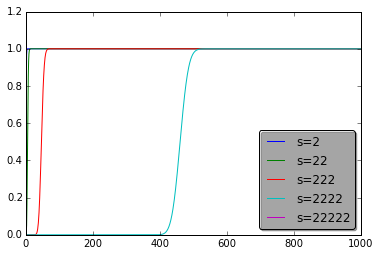

In [39]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.

S = [2, 22, 222, 2222, 22222]
best_tau = 1e-300
plt.figure()
for s in S:
    best = iv_s_mpfr(s, s, tau=best_tau)
    rel_err = [iv_s_eq7(s, s, order) / best for order in range(1000)]
    plt.plot(range(1000), rel_err, label="s={}".format(s))
plt.legend(shadow=True, fancybox=True, loc="bottom right")
    
        
    
    

context(precision=100, real_prec=Default, imag_prec=Default,
        round=RoundToNearest, real_round=Default, imag_round=Default,
        emax=1073741823, emin=-1073741823,
        subnormalize=False,
        trap_underflow=False, underflow=False,
        trap_overflow=False, overflow=False,
        trap_inexact=False, inexact=True,
        trap_invalid=False, invalid=False,
        trap_erange=False, erange=False,
        trap_divzero=False, divzero=False,
        trap_expbound=False,
        allow_complex=False)